<a href="https://colab.research.google.com/github/hellomstars/DeepLearning/blob/main/DNN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 심층 신경망 훈련 2
#### : 훈련 알고리즘

In [ ]:
import sklearn
import tensorflow as tf
from tensorflow import keras
%load_ext tensorboard
import numpy as np
import os
np.random.seed(42)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 고속 옵티마이저

## 학습률 스케줄링

### 거듭제곱 스케줄링

In [ ]:
#lr = lr0 / (1 + steps / s)**c
#케라스는 c=1과 s = 1 / decay 사용

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data() #fashion mnist 데이터를 통해 train / test 데이터를 분리한다다
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
#X_train_A: 샌달과 셔츠(클래스 5와 6)을 제외한 모든 이미지
#X_train_B: 샌달과 셔츠 이미지 중 처음 200개만 가진 작은 훈련 세트

def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) #샌달 또는 셔츠
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 #7,8,9 클래스 2칸씩 이동. 즉, 5,6,7로 이동
    y_B = (y[y_5_or_6] == 6).astype(np.float32) #분류
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train) #데이터 분리해 train 데이터 생성
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid) #데이터 분리해 valid 데이터 생성
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4) #확률적 경사 하강법으로 최적화시킨다다

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"), #selu 활성함수로 레이어 생성
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax") #출력레이어는 softmax 활성함수로 생성성
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]) #모델 컴파일일

In [ ]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds #스케일링 해준다다
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [ ]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid)) #모델 학습으로 loss 값이 줄어든다다

Epoch 1/25
1719/1719 [==============================] - 7s 3ms/step - loss: 0.4891 - accuracy: 0.8285 - val_loss: 0.4243 - val_accuracy: 0.8514
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3826 - accuracy: 0.8651 - val_loss: 0.3864 - val_accuracy: 0.8640
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3498 - accuracy: 0.8757 - val_loss: 0.3703 - val_accuracy: 0.8672
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3281 - accuracy: 0.8834 - val_loss: 0.3567 - val_accuracy: 0.8730
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3123 - accuracy: 0.8902 - val_loss: 0.3523 - val_accuracy: 0.8780
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2987 - accuracy: 0.8943 - val_loss: 0.3442 - val_accuracy: 0.8790
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2886 - accuracy: 0.8978 - val_loss: 0.3442 - val_accuracy:

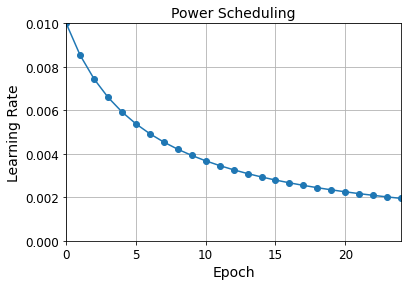

In [ ]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-") #각 epoch별 lrs를 점으로 표시한다다
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### 지수 기반 스케줄링

In [ ]:
#lr = lr0 * 0.1**(epoch / s)

In [ ]:
def exponential_decay_fn(epoch): #지수 기반 함수 설정정
    return 0.01 * 0.1**(epoch / 20)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [ ]:
model = keras.models.Sequential([ #모델 생성성
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"]) #모델 컴파일
n_epochs = 25

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 10s 5ms/step - loss: 0.8829 - accuracy: 0.7429 - val_loss: 0.8116 - val_accuracy: 0.7612 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.7226 - accuracy: 0.7847 - val_loss: 0.7800 - val_accuracy: 0.7800 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6400 - accuracy: 0.8098 - val_loss: 0.6193 - val_accuracy: 0.8216 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5883 - accuracy: 0.8267 - val_loss: 0.5897 - val_accuracy: 0.8272 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5457 - accuracy: 0.8374 - val_loss: 0.6283 - val_accuracy: 0.8428 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4797 - accuracy: 0.8539 - val_loss: 0.5600 - val_accuracy: 0.8470 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] - 6

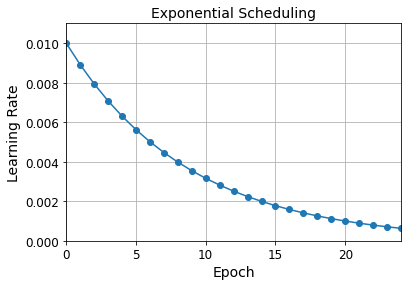

In [ ]:
plt.plot(history.epoch, history.history["lr"], "o-") #각 epoch 별 lr에 대한 history 점으로 표시시
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20) #두 번째 매개변수로 현재 학습률

In [ ]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        #에포크마다 batch 매개변수가 재설정됩니다
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / self.s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # 20 에포크 동안 스텝 횟수 (배치 크기 = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.8038 - accuracy: 0.7676 - val_loss: 0.7767 - val_accuracy: 0.8004 - lr: 0.0089
Epoch 2/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.6465 - accuracy: 0.8030 - val_loss: 0.5958 - val_accuracy: 0.8052 - lr: 0.0079
Epoch 3/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5464 - accuracy: 0.8290 - val_loss: 0.5376 - val_accuracy: 0.8604 - lr: 0.0071
Epoch 4/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5052 - accuracy: 0.8411 - val_loss: 0.6226 - val_accuracy: 0.8260 - lr: 0.0063
Epoch 5/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4710 - accuracy: 0.8520 - val_loss: 0.4640 - val_accuracy: 0.8522 - lr: 0.0056
Epoch 6/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4172 - accuracy: 0.8662 - val_loss: 0.5025 - val_accuracy: 0.8576 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 8s

In [ ]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

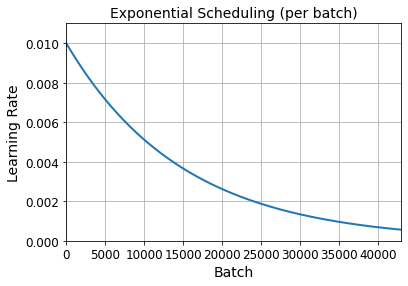

In [ ]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14) #배치 별 지수 기반 스케줄링 출력력
plt.grid(True)
plt.show()

### 기간별 고정 스케줄링

In [ ]:
def piecewise_constant_fn(epoch): #기간별 스케줄링 함수 설정정
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [ ]:
def piecewise_constant(boundaries, values): #고정값 설정정
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn) #콜백을 이용해 스케줄링링

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.8520 - accuracy: 0.7581 - val_loss: 0.7981 - val_accuracy: 0.7916 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.9051 - accuracy: 0.7356 - val_loss: 0.9714 - val_accuracy: 0.6812 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 1.0025 - accuracy: 0.6712 - val_loss: 1.0331 - val_accuracy: 0.6734 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 6s 4ms/step - loss: 1.1067 - accuracy: 0.6589 - val_loss: 1.0799 - val_accuracy: 0.6480 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 6s 4ms/step - loss: 1.1431 - accuracy: 0.6376 - val_loss: 1.0887 - val_accuracy: 0.6706 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.7350 - accuracy: 0.7325 - val_loss: 0.8132 - val_accuracy: 0.7426 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 6s

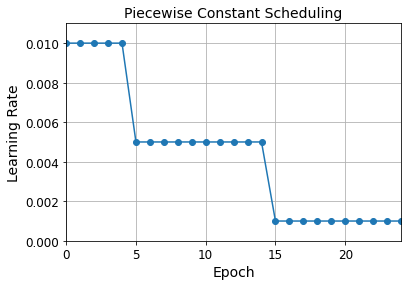

In [ ]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14) #기간 별 고정 스케줄링 출력력
plt.grid(True)
plt.show()

### 성능 기반 스케줄링

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5942 - accuracy: 0.8057 - val_loss: 0.4734 - val_accuracy: 0.8514 - lr: 0.0200
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4920 - accuracy: 0.8409 - val_loss: 0.5838 - val_accuracy: 0.8334 - lr: 0.0200
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5202 - accuracy: 0.8396 - val_loss: 0.5358 - val_accuracy: 0.8460 - lr: 0.0200
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5067 - accuracy: 0.8470 - val_loss: 0.4557 - val_accuracy: 0.8564 - lr: 0.0200
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5223 - accuracy: 0.8503 - val_loss: 0.5042 - val_accuracy: 0.8462 - lr: 0.0200
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4999 - accuracy: 0.8567 - val_loss: 0.6310 - val_accuracy: 0.8416 - lr: 0.0200
Epoch 7/25
1719/1719 [==============================] - 5s

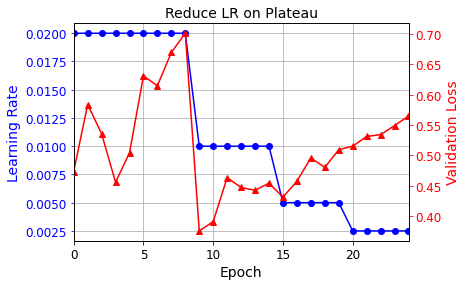

In [ ]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras 스케줄러

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4894 - accuracy: 0.8274 - val_loss: 0.4092 - val_accuracy: 0.8604
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3820 - accuracy: 0.8651 - val_loss: 0.3738 - val_accuracy: 0.8696
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3487 - accuracy: 0.8767 - val_loss: 0.3733 - val_accuracy: 0.8684
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3264 - accuracy: 0.8838 - val_loss: 0.3491 - val_accuracy: 0.8808
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3104 - accuracy: 0.8898 - val_loss: 0.3430 - val_accuracy: 0.8798
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2958 - accuracy: 0.8953 - val_loss: 0.3416 - val_accuracy: 0.8812
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2854 - accuracy: 0.8987 - val_loss: 0.3356 - val_accuracy:

In [ ]:
#구간별 고정 스케줄링
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

# 규제를 사용해 과대적합 피하기

## $\ell_1$과 $\ell_2$ 규제

In [ ]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor of 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 7s 4ms/step - loss: 1.5816 - accuracy: 0.8115 - val_loss: 0.7197 - val_accuracy: 0.8302
Epoch 2/2
1719/1719 [==============================] - 7s 4ms/step - loss: 0.7210 - accuracy: 0.8276 - val_loss: 0.6862 - val_accuracy: 0.8360


In [ ]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 8s 4ms/step - loss: 1.6630 - accuracy: 0.8122 - val_loss: 0.7201 - val_accuracy: 0.8308
Epoch 2/2
1719/1719 [==============================] - 6s 4ms/step - loss: 0.7188 - accuracy: 0.8266 - val_loss: 0.6806 - val_accuracy: 0.8402


## 드롭아웃

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5709 - accuracy: 0.8030 - val_loss: 0.3613 - val_accuracy: 0.8728
Epoch 2/2
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4181 - accuracy: 0.8464 - val_loss: 0.3495 - val_accuracy: 0.8688


## 알파 드롭아웃

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6617 - accuracy: 0.7611 - val_loss: 0.5763 - val_accuracy: 0.8408
Epoch 2/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5547 - accuracy: 0.7965 - val_loss: 0.5437 - val_accuracy: 0.8480
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5256 - accuracy: 0.8060 - val_loss: 0.5016 - val_accuracy: 0.8560
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5048 - accuracy: 0.8135 - val_loss: 0.4786 - val_accuracy: 0.8586
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4921 - accuracy: 0.8170 - val_loss: 0.4658 - val_accuracy: 0.8618
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4839 - accuracy: 0.8203 - val_loss: 0.4882 - val_accuracy: 0.8574
Epoch 7/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4715 - accuracy: 0.8251 - val_loss: 0.5065 - val_accuracy:

In [ ]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.4650 - accuracy: 0.8624


[0.46503618359565735, 0.8623999953269958]

In [ ]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 5s 3ms/step - loss: 0.3388 - accuracy: 0.8847


[0.3388313949108124, 0.8846908807754517]

In [ ]:
history = model.fit(X_train_scaled, y_train)

1719/1719 [==============================] - 5s 3ms/step - loss: 0.4181 - accuracy: 0.8438


## MC 드롭아웃

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [ ]:
np.round(model.predict(X_test_scaled[:1]), 2) #모델 예측에 대한 소숫점 2자리리

1/1 [==============================] - 0s 73ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],
      dtype=float32)

In [ ]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.39, 0.  , 0.21, 0.  , 0.41]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.35, 0.  , 0.61]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.33, 0.  , 0.63]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.09, 0.  , 0.87]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.22, 0.  , 0.2 , 0.  , 0.57]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.19, 0.  , 0.53, 0.  , 0.28]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.97]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.87, 0.  , 0.06, 0.  , 0.07]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.33, 0.  , 0.67]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.15, 0.  , 0.81]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.12, 0.  , 0.8 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.45, 0.  , 0.11, 0.  , 0.44]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.  , 0.  , 0.9 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.09, 0.  , 0

In [ ]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.16, 0.  , 0.23, 0.  , 0.61]],
      dtype=float32)

In [ ]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.22, 0.  , 0.21, 0.01, 0.29]],
      dtype=float32)

In [ ]:
y_pred = np.argmax(y_proba, axis=1)

In [ ]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy #정확도 86%

0.8685

In [ ]:
class MCDropout(keras.layers.Dropout): #클래스 생성성
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [ ]:
mc_model.summary() #레이어 784개, 300개, 100개, 출력 10개개

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 784)               0         
                                                                 
 mc_alpha_dropout (MCAlphaDr  (None, 784)              0         
 opout)                                                          
                                                                 
 dense_28 (Dense)            (None, 300)               235500    
                                                                 
 mc_alpha_dropout_1 (MCAlpha  (None, 300)              0         
 Dropout)                                                        
                                                                 
 dense_29 (Dense)            (None, 100)               30100     
                                                                 
 mc_alpha_dropout_2 (MCAlpha  (None, 100)            

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True) #최적화 실행행
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]) #모델 컴파일일

In [ ]:
mc_model.set_weights(model.get_weights()) #모델 가중치 설정

In [ ]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

1/1 [==============================] - 0s 14ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.12, 0.  , 0.27, 0.  , 0.61]],
      dtype=float32)

## 맥스 노름

In [ ]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [ ]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4743 - accuracy: 0.8330 - val_loss: 0.3746 - val_accuracy: 0.8616
Epoch 2/2
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3544 - accuracy: 0.8706 - val_loss: 0.3784 - val_accuracy: 0.8654


# 텐서와 연산

## 텐서

In [ ]:
tf.constant([[1., 2., 3.], [4., 5., 6.]]) # 행렬

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [ ]:
tf.constant(42) # 스칼라

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [ ]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
t

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [ ]:
print(t.shape)

(2, 3)


#### 인덱싱

In [ ]:
t[:, 1:] #:을 통해  배열 인덱싱

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [ ]:
t[..., 1, tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

## 넘파이 변환

In [ ]:
a = np.array([2., 4., 5.])
tf.constant(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [ ]:
t.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [ ]:
np.array(t)

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [ ]:
tf.square(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [ ]:
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

## 변수

In [ ]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])

In [ ]:
v.assign(2 * v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [ ]:
v[0, 1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [ ]:
v[:, 2].assign([0., 1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

In [ ]:
try:
    v[1] = [7., 8., 9.]
except TypeError as ex:
    print(ex)

'ResourceVariable' object does not support item assignment


In [ ]:
v.scatter_nd_update(indices=[[0, 0], [1, 2]],
                    updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

In [ ]:
sparse_delta = tf.IndexedSlices(values=[[1., 2., 3.], [4., 5., 6.]],
                                indices=[1, 0])
v.scatter_update(sparse_delta)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[4., 5., 6.],
       [1., 2., 3.]], dtype=float32)>

## 사용자 정의 손실 함수

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [ ]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

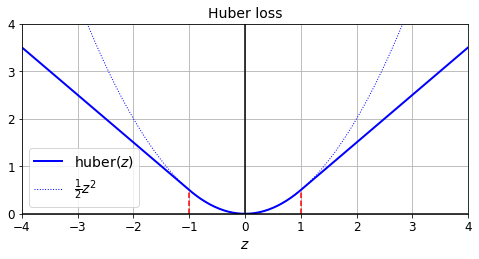

In [ ]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [ ]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [ ]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 0.5887 - mae: 0.9436 - val_loss: 0.2080 - val_mae: 0.4985
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.2091 - mae: 0.5037 - val_loss: 0.1924 - val_mae: 0.4774


## 사용자 정의 요소를 가진 모델을 저장하고 로드하기

In [ ]:
model.save("my_model_with_a_custom_loss.h5")

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_loss.h5",
                                custom_objects={"huber_fn": huber_fn})

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 0.2006 - mae: 0.4915 - val_loss: 0.1857 - val_mae: 0.4658
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.1960 - mae: 0.4849 - val_loss: 0.1807 - val_mae: 0.4617


In [ ]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [ ]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 0.2177 - mae: 0.4841 - val_loss: 0.1973 - val_mae: 0.4559
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2131 - mae: 0.4794 - val_loss: 0.2217 - val_mae: 0.4738


In [ ]:
model.save("my_model_with_a_custom_loss_threshold_2.h5")

In [ ]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [ ]:
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 0.9529 - mae: 1.0126 - val_loss: 0.3444 - val_mae: 0.5640
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2463 - mae: 0.5133 - val_loss: 0.2900 - val_mae: 0.5212


In [ ]:
model.save("my_model_with_a_custom_loss_class.h5")

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_loss_class.h5",
                                custom_objects={"HuberLoss": HuberLoss})

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 0.2304 - mae: 0.4972 - val_loss: 0.2061 - val_mae: 0.4709
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2217 - mae: 0.4887 - val_loss: 0.2132 - val_mae: 0.4750


In [ ]:
model.loss.threshold

2.0

## 텐서플로 함수

In [ ]:
def cube(x):
    return x ** 3 #x의 3제곱에 대한 함수 설정

In [ ]:
cube(2) #x값에 2 대입

8

In [ ]:
cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [ ]:
tf_cube = tf.function(cube)
tf_cube

In [ ]:
tf_cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [ ]:
tf_cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>